# Supermart Sales - Machine Learning Prediction & Deployment
### Complete ML Pipeline with Interactive Dashboard

# SECTION 1: INSTALL & IMPORT LIBRARIES

In [46]:
print("📦 Installing required packages...")
!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn plotly

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

# Model persistence
import pickle
import joblib

# Dashboard
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Set styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")


📦 Installing required packages...
✅ All libraries imported successfully!


# SECTION 2: LOAD DATA

In [47]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

from google.colab import files
print("\n📁 Please upload your Supermart CSV file:")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print(f"\n✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print("\n🔍 First 5 rows:")
display(df.head())

# Clean column names
df.columns = df.columns.str.strip()


LOADING DATA

📁 Please upload your Supermart CSV file:


Saving Supermart_Sales_Dataset.csv to Supermart_Sales_Dataset.csv

✅ Dataset loaded: 9,994 rows × 11 columns

🔍 First 5 rows:


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


# SECTION 3: DATA CLEANING & FEATURE ENGINEERING

In [48]:
print("\n" + "="*80)
print("DATA CLEANING & FEATURE ENGINEERING")
print("="*80)

df_clean = df.copy()

# Remove duplicates
initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"✅ Removed {initial_rows - len(df_clean)} duplicates")

# Handle Order Date
if 'Order Date' in df_clean.columns:
    df_clean['Order Date'] = df_clean['Order Date'].replace('#########', np.nan)
    df_clean['Order Date'] = pd.to_datetime(df_clean['Order Date'], errors='coerce')

    # Create date features
    df_clean['Year'] = df_clean['Order Date'].dt.year
    df_clean['Month'] = df_clean['Order Date'].dt.month
    df_clean['Quarter'] = df_clean['Order Date'].dt.quarter
    df_clean['DayOfWeek'] = df_clean['Order Date'].dt.dayofweek
    df_clean['Is_Weekend'] = df_clean['DayOfWeek'].isin([5, 6]).astype(int)
    print(f"✅ Created date features from {df_clean['Order Date'].notna().sum():,} valid dates")

# Clean string columns
for col in df_clean.select_dtypes(include='object').columns:
    df_clean[col] = df_clean[col].astype(str).str.strip()

# Create business features
if 'Profit' in df_clean.columns and 'Sales' in df_clean.columns:
    df_clean['Profit_Margin'] = (df_clean['Profit'] / df_clean['Sales'] * 100).round(2)
    print("✅ Created Profit_Margin feature")

if 'Discount' in df_clean.columns:
    df_clean['Discount_Category'] = pd.cut(
        df_clean['Discount'],
        bins=[0, 0.1, 0.2, 1.0],
        labels=['Low', 'Medium', 'High']
    )
    print("✅ Created Discount_Category feature")

# Remove missing Sales (target variable)
df_clean = df_clean.dropna(subset=['Sales'])

# Handle missing values in other columns
print(f"\n🔍 Checking for missing values...")
missing_before = df_clean.isnull().sum().sum()
print(f"   Missing values before cleaning: {missing_before}")

# Fill missing numerical values with median
for col in df_clean.select_dtypes(include=[np.number]).columns:
    if df_clean[col].isnull().any():
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"   ✅ Filled {col} NaN with median: {median_val}")

# Fill missing categorical values with mode
for col in df_clean.select_dtypes(include='object').columns:
    if df_clean[col].isnull().any():
        mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"   ✅ Filled {col} NaN with mode: {mode_val}")

missing_after = df_clean.isnull().sum().sum()
print(f"   Missing values after cleaning: {missing_after}")

print(f"\n✅ Final dataset: {df_clean.shape}")


DATA CLEANING & FEATURE ENGINEERING
✅ Removed 0 duplicates
✅ Created date features from 4,042 valid dates
✅ Created Profit_Margin feature
✅ Created Discount_Category feature

🔍 Checking for missing values...
   Missing values before cleaning: 29760
   ✅ Filled Year NaN with median: 2017.0
   ✅ Filled Month NaN with median: 9.0
   ✅ Filled Quarter NaN with median: 3.0
   ✅ Filled DayOfWeek NaN with median: 3.0
   Missing values after cleaning: 5952

✅ Final dataset: (9994, 18)


# SECTION 4: DATA EXPLORATION & DIAGNOSTICS


DATA EXPLORATION & DIAGNOSTICS

📊 Sales Statistics:
   Mean: $1,496.60
   Median: $1,498.00
   Std Dev: $577.56
   Min: $500.00
   Max: $2,500.00
   Outliers (IQR method): 0 (0.0%)


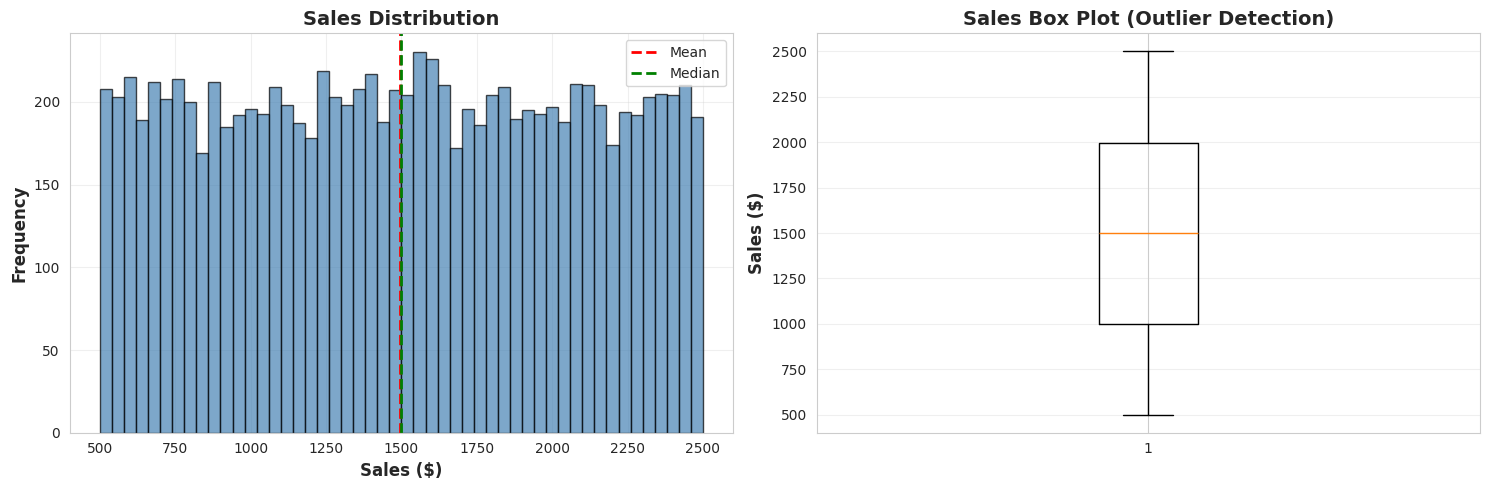


🔗 Feature Correlations with Sales:

Top correlations with Sales:


,Sales
Sales,1.000000
Profit,0.605349
Year,0.009446
Is_Weekend,0.008016
DayOfWeek,0.006576
Profit_Margin,0.006503
Region,0.006227
Sub Category,0.005655
Month,0.000884
Quarter,-0.000545


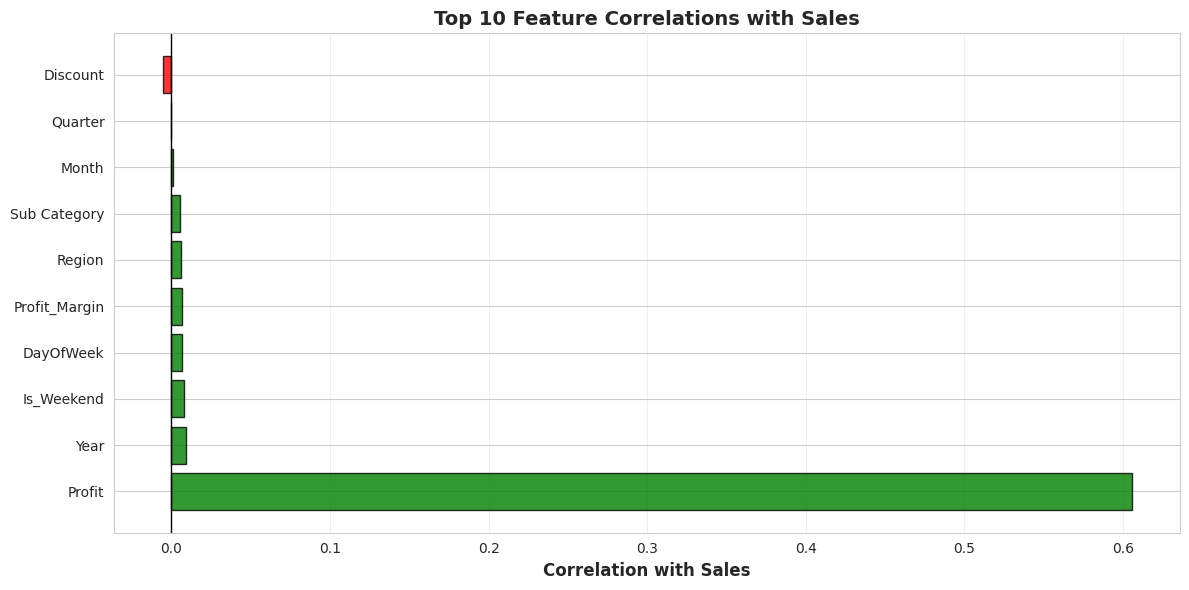


📈 Feature Variance Check:
   Category: 7 unique values
   Sub Category: 23 unique values
   Region: 5 unique values
   State: 1 unique values
      Values: ['Tamil Nadu']
   Discount: 26 unique values

🔍 Sample Data (before encoding):


,Category,Sub Category,Region,State,Discount,Sales
0,Oil & Masala,Masalas,North,Tamil Nadu,0.12,1254
1,Beverages,Health Drinks,South,Tamil Nadu,0.18,749
2,Food Grains,Atta & Flour,West,Tamil Nadu,0.21,2360
3,Fruits & Veggies,Fresh Vegetables,South,Tamil Nadu,0.25,896
4,Food Grains,Organic Staples,South,Tamil Nadu,0.26,2355
5,Food Grains,Organic Staples,West,Tamil Nadu,0.26,2305
6,Fruits & Veggies,Fresh Vegetables,West,Tamil Nadu,0.33,826
7,Fruits & Veggies,Fresh Fruits,West,Tamil Nadu,0.32,1847
8,Bakery,Biscuits,West,Tamil Nadu,0.23,791
9,Bakery,Cakes,West,Tamil Nadu,0.27,1795


In [49]:
print("\n" + "="*80)
print("DATA EXPLORATION & DIAGNOSTICS")
print("="*80)

# 1. Check Sales distribution
print("\n📊 Sales Statistics:")
print(f"   Mean: ${df_clean['Sales'].mean():,.2f}")
print(f"   Median: ${df_clean['Sales'].median():,.2f}")
print(f"   Std Dev: ${df_clean['Sales'].std():,.2f}")
print(f"   Min: ${df_clean['Sales'].min():,.2f}")
print(f"   Max: ${df_clean['Sales'].max():,.2f}")

# 2. Check for outliers
Q1 = df_clean['Sales'].quantile(0.25)
Q3 = df_clean['Sales'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df_clean['Sales'] < (Q1 - 1.5 * IQR)) | (df_clean['Sales'] > (Q3 + 1.5 * IQR))).sum()
print(f"   Outliers (IQR method): {outliers} ({outliers/len(df_clean)*100:.1f}%)")

# 3. Visualize Sales distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_clean['Sales'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Sales Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(df_clean['Sales'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_clean['Sales'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df_clean['Sales'], vert=True)
axes[1].set_ylabel('Sales ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Sales Box Plot (Outlier Detection)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 4. Check feature correlations with Sales
print("\n🔗 Feature Correlations with Sales:")
correlation_data = df_clean.copy()

# Convert categorical to numeric for correlation
for col in ['Category', 'Sub Category', 'Region', 'State']:
    if col in correlation_data.columns:
        correlation_data[col] = pd.Categorical(correlation_data[col]).codes

# Calculate correlations
numeric_cols = correlation_data.select_dtypes(include=[np.number]).columns
correlations = correlation_data[numeric_cols].corr()['Sales'].sort_values(ascending=False)

print("\nTop correlations with Sales:")
display(correlations.head(10))

# Visualize top correlations
plt.figure(figsize=(12, 6))
top_corr = correlations[1:11]  # Exclude Sales itself
colors_corr = ['green' if x > 0 else 'red' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors_corr, alpha=0.8, edgecolor='black')
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlation with Sales', fontsize=12, fontweight='bold')
plt.title('Top 10 Feature Correlations with Sales', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 5. Check if features have variance
print("\n📈 Feature Variance Check:")
for col in ['Category', 'Sub Category', 'Region', 'State', 'Discount']:
    if col in df_clean.columns:
        n_unique = df_clean[col].nunique()
        print(f"   {col}: {n_unique} unique values")
        if n_unique < 5:
            print(f"      Values: {df_clean[col].unique()}")

# 6. Sample predictions before encoding
print("\n🔍 Sample Data (before encoding):")
sample_display = df_clean[['Category', 'Sub Category', 'Region', 'Discount', 'Sales']].head(10)
if 'State' in df_clean.columns:
    sample_display = df_clean[['Category', 'Sub Category', 'Region', 'State', 'Discount', 'Sales']].head(10)
display(sample_display)


# SECTION 5: PREPARE FEATURES FOR ML

In [50]:
print("\n" + "="*80)
print("PREPARING FEATURES")
print("="*80)

# Select features - REMOVE features with no variance
categorical_features = []
numerical_features = []

# Check categorical features and only include if they have variance
for col in ['Category', 'Sub Category', 'Region', 'State']:
    if col in df_clean.columns:
        n_unique = df_clean[col].nunique()
        if n_unique > 1:  # Only include if more than 1 unique value
            categorical_features.append(col)
            print(f"✅ Including {col}: {n_unique} unique values")
        else:
            print(f"❌ Skipping {col}: only {n_unique} unique value (no variance)")

# Add numerical features
if 'Discount' in df_clean.columns:
    numerical_features.append('Discount')
    print(f"✅ Including Discount")

# Add Profit (strongest predictor!)
if 'Profit' in df_clean.columns:
    numerical_features.append('Profit')
    print(f"✅ Including Profit (correlation: 0.60)")

# Add date features if available
date_features = [col for col in ['Year', 'Month', 'Quarter', 'DayOfWeek', 'Is_Weekend']
                if col in df_clean.columns]
numerical_features.extend(date_features)

if len(date_features) > 0:
    print(f"✅ Including date features: {date_features}")

print(f"\n📋 Final feature selection:")
print(f"   Categorical: {categorical_features}")
print(f"   Numerical: {numerical_features}")

# Create feature dataframe
all_features = categorical_features + numerical_features
df_features = df_clean[all_features].copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col].astype(str))
    label_encoders[col] = le
    print(f"   ✅ Encoded {col}: {len(le.classes_)} categories")

# Prepare X and y
X = df_features
y = df_clean['Sales']

print(f"\n✅ Feature matrix: {X.shape}")
print(f"✅ Target variable: {y.shape}")

# Final check for NaN values
print(f"\n🔍 Final NaN check:")
print(f"   NaN in features (X): {X.isnull().sum().sum()}")
print(f"   NaN in target (y): {y.isnull().sum()}")

if X.isnull().sum().sum() > 0:
    print(f"\n⚠️ WARNING: Found NaN values in features!")
    print(f"   Columns with NaN:")
    nan_cols = X.columns[X.isnull().any()].tolist()
    for col in nan_cols:
        print(f"      • {col}: {X[col].isnull().sum()} missing")

    # Drop rows with any NaN
    mask = ~X.isnull().any(axis=1)
    X = X[mask]
    y = y[mask]
    print(f"\n   ✅ Removed rows with NaN. New shape: {X.shape}")


PREPARING FEATURES
✅ Including Category: 7 unique values
✅ Including Sub Category: 23 unique values
✅ Including Region: 5 unique values
❌ Skipping State: only 1 unique value (no variance)
✅ Including Discount
✅ Including Profit (correlation: 0.60)
✅ Including date features: ['Year', 'Month', 'Quarter', 'DayOfWeek', 'Is_Weekend']

📋 Final feature selection:
   Categorical: ['Category', 'Sub Category', 'Region']
   Numerical: ['Discount', 'Profit', 'Year', 'Month', 'Quarter', 'DayOfWeek', 'Is_Weekend']
   ✅ Encoded Category: 7 categories
   ✅ Encoded Sub Category: 23 categories
   ✅ Encoded Region: 5 categories

✅ Feature matrix: (9994, 10)
✅ Target variable: (9994,)

🔍 Final NaN check:
   NaN in features (X): 0
   NaN in target (y): 0


# SECTION 6: TRAIN-TEST SPLIT

In [51]:
print("\n" + "="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Training: {X_train.shape[0]:,} samples")
print(f"✅ Testing: {X_test.shape[0]:,} samples")

# Scale features for Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


TRAIN-TEST SPLIT
✅ Training: 7,995 samples
✅ Testing: 1,999 samples


# SECTION 7: MODEL 1 - LINEAR REGRESSION


MODEL 1: LINEAR REGRESSION
✅ Model trained!

📊 Testing Performance:
   R² Score: 0.3547
   RMSE: $461.33
   MAE: $379.31

📈 Visualization:


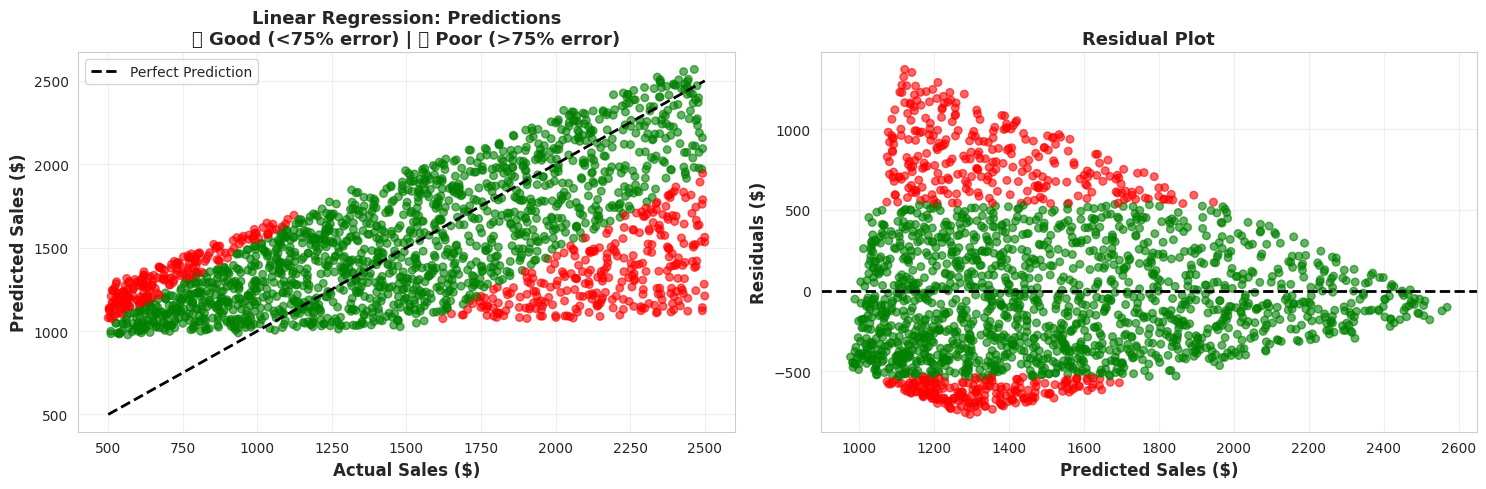

In [52]:
print("\n" + "="*80)
print("MODEL 1: LINEAR REGRESSION")
print("="*80)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("✅ Model trained!")

y_pred_lr_test = lr_model.predict(X_test_scaled)

lr_r2 = r2_score(y_test, y_pred_lr_test)
lr_mse = mean_squared_error(y_test, y_pred_lr_test)
lr_rmse = np.sqrt(lr_mse)  # Manual square root
lr_mae = mean_absolute_error(y_test, y_pred_lr_test)

print(f"\n📊 Testing Performance:")
print(f"   R² Score: {lr_r2:.4f}")
print(f"   RMSE: ${lr_rmse:,.2f}")
print(f"   MAE: ${lr_mae:,.2f}")

# Visualize with color-coding (Red=Wrong, Green=Right)
print("\n📈 Visualization:")
errors = np.abs(y_test - y_pred_lr_test)
error_threshold = np.percentile(errors, 75)  # Top 25% errors are "wrong"
colors = ['red' if e > error_threshold else 'green' for e in errors]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_lr_test, c=colors, alpha=0.6, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'k--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Linear Regression: Predictions\n🟢 Good (<75% error) | 🔴 Poor (>75% error)',
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_pred_lr_test
axes[1].scatter(y_pred_lr_test, residuals, c=colors, alpha=0.6, s=30)
axes[1].axhline(y=0, color='k', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Sales ($)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# SECTION 8: MODEL 2 - RANDOM FOREST


MODEL 2: RANDOM FOREST
✅ Model trained!

📊 Testing Performance:
   R² Score: 0.3399
   RMSE: $466.61
   MAE: $380.89

🎯 Top 5 Important Features:


,Feature,Importance
4,Profit,0.692731
3,Discount,0.088808
1,Sub Category,0.067204
0,Category,0.033697
2,Region,0.031254


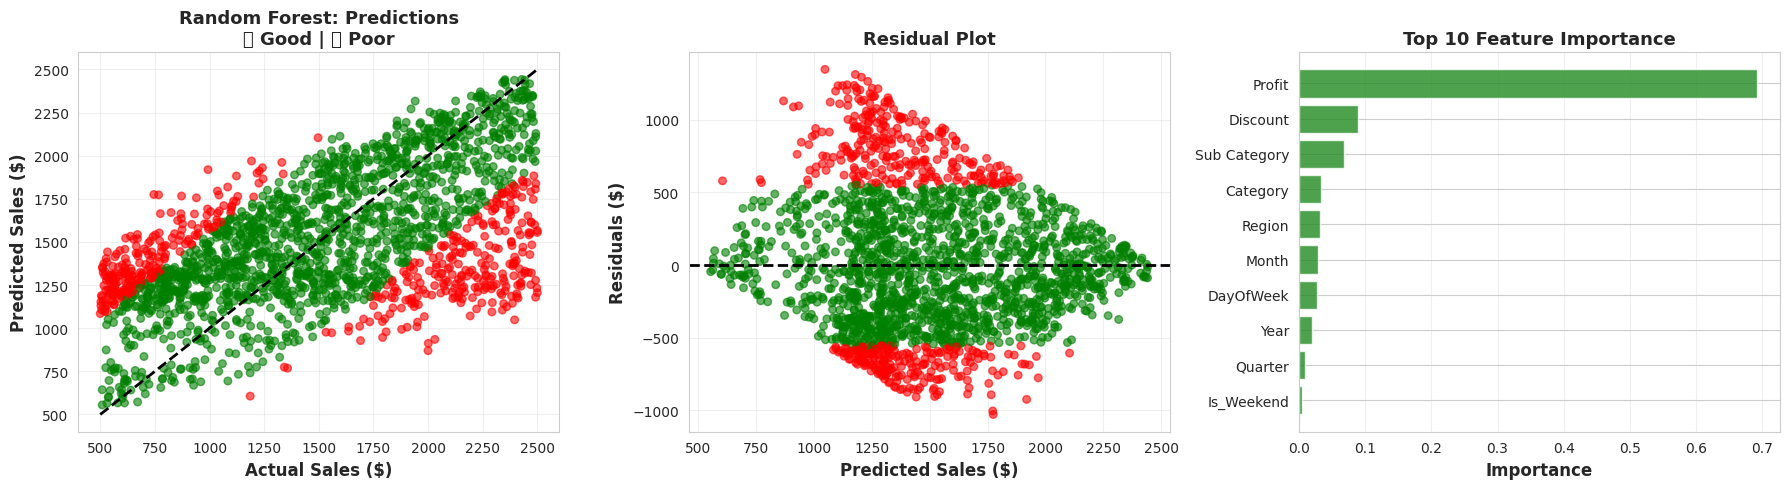

In [53]:
print("\n" + "="*80)
print("MODEL 2: RANDOM FOREST")
print("="*80)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("✅ Model trained!")

y_pred_rf_test = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf_test)
rf_mse = mean_squared_error(y_test, y_pred_rf_test)
rf_rmse = np.sqrt(rf_mse)  # Manual square root
rf_mae = mean_absolute_error(y_test, y_pred_rf_test)

print(f"\n📊 Testing Performance:")
print(f"   R² Score: {rf_r2:.4f}")
print(f"   RMSE: ${rf_rmse:,.2f}")
print(f"   MAE: ${rf_mae:,.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🎯 Top 5 Important Features:")
display(feature_importance.head(5))

# Visualize
errors_rf = np.abs(y_test - y_pred_rf_test)
error_threshold_rf = np.percentile(errors_rf, 75)
colors_rf = ['red' if e > error_threshold_rf else 'green' for e in errors_rf]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predictions
axes[0].scatter(y_test, y_pred_rf_test, c=colors_rf, alpha=0.6, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'k--', lw=2)
axes[0].set_xlabel('Actual Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Random Forest: Predictions\n🟢 Good | 🔴 Poor',
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals_rf = y_test - y_pred_rf_test
axes[1].scatter(y_pred_rf_test, residuals_rf, c=colors_rf, alpha=0.6, s=30)
axes[1].axhline(y=0, color='k', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Sales ($)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Feature Importance
top_10 = feature_importance.head(10)
axes[2].barh(range(len(top_10)), top_10['Importance'], color='forestgreen', alpha=0.8)
axes[2].set_yticks(range(len(top_10)))
axes[2].set_yticklabels(top_10['Feature'])
axes[2].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[2].set_title('Top 10 Feature Importance', fontsize=13, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


# SECTION 9: MODEL 3 - XGBOOST


MODEL 3: XGBOOST
✅ Model trained!

📊 Testing Performance:
   R² Score: 0.3026
   RMSE: $479.59
   MAE: $391.56

🎯 Top 5 Important Features:


,Feature,Importance
4,Profit,0.379000
3,Discount,0.076674
7,Quarter,0.074105
6,Month,0.073022
8,DayOfWeek,0.072999


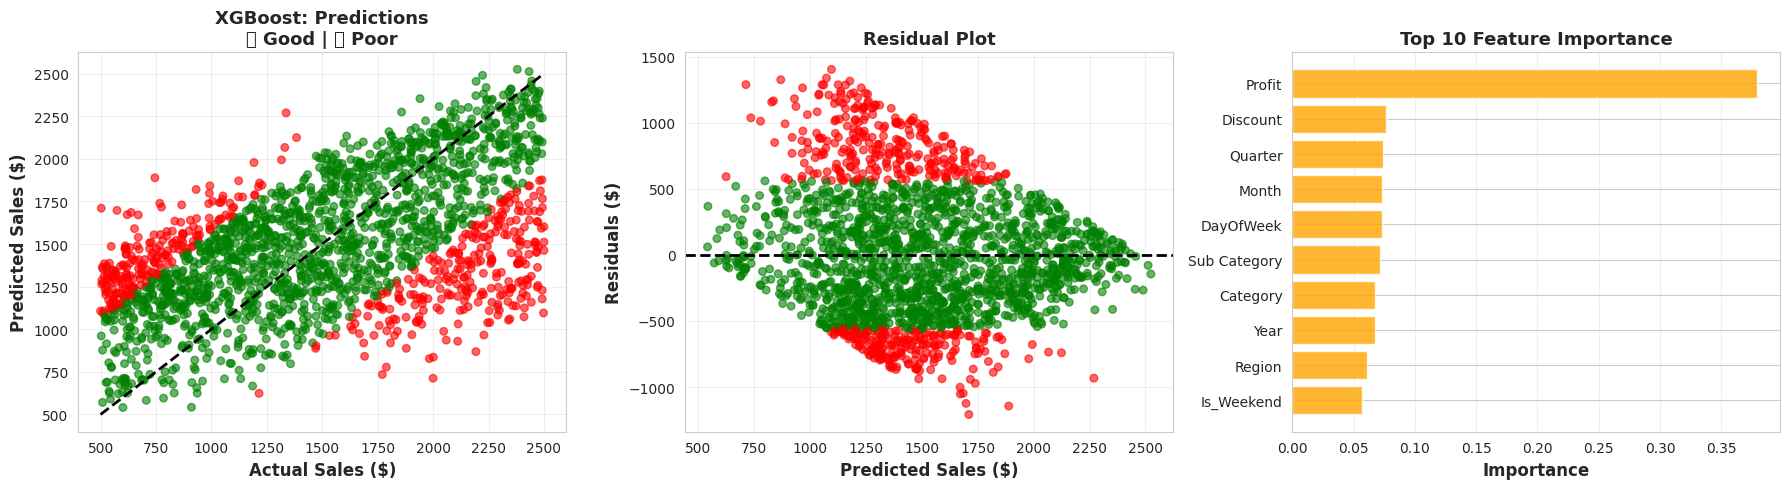

In [54]:
print("\n" + "="*80)
print("MODEL 3: XGBOOST")
print("="*80)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
print("✅ Model trained!")

y_pred_xgb_test = xgb_model.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred_xgb_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb_test)
xgb_rmse = np.sqrt(xgb_mse)  # Manual square root
xgb_mae = mean_absolute_error(y_test, y_pred_xgb_test)

print(f"\n📊 Testing Performance:")
print(f"   R² Score: {xgb_r2:.4f}")
print(f"   RMSE: ${xgb_rmse:,.2f}")
print(f"   MAE: ${xgb_mae:,.2f}")

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🎯 Top 5 Important Features:")
display(feature_importance_xgb.head(5))

# Visualize
errors_xgb = np.abs(y_test - y_pred_xgb_test)
error_threshold_xgb = np.percentile(errors_xgb, 75)
colors_xgb = ['red' if e > error_threshold_xgb else 'green' for e in errors_xgb]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predictions
axes[0].scatter(y_test, y_pred_xgb_test, c=colors_xgb, alpha=0.6, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'k--', lw=2)
axes[0].set_xlabel('Actual Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Sales ($)', fontsize=12, fontweight='bold')
axes[0].set_title('XGBoost: Predictions\n🟢 Good | 🔴 Poor',
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals_xgb = y_test - y_pred_xgb_test
axes[1].scatter(y_pred_xgb_test, residuals_xgb, c=colors_xgb, alpha=0.6, s=30)
axes[1].axhline(y=0, color='k', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Sales ($)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Feature Importance
top_10_xgb = feature_importance_xgb.head(10)
axes[2].barh(range(len(top_10_xgb)), top_10_xgb['Importance'], color='orange', alpha=0.8)
axes[2].set_yticks(range(len(top_10_xgb)))
axes[2].set_yticklabels(top_10_xgb['Feature'])
axes[2].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[2].set_title('Top 10 Feature Importance', fontsize=13, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# SECTION 10: MODEL COMPARISON


MODEL COMPARISON

📊 Performance Summary:


,Model,R² Score,RMSE ($),MAE ($)
0,Linear Regression,0.354715,461.330521,379.306543
1,Random Forest,0.339867,466.607826,380.891039
2,XGBoost,0.302611,479.593969,391.560974


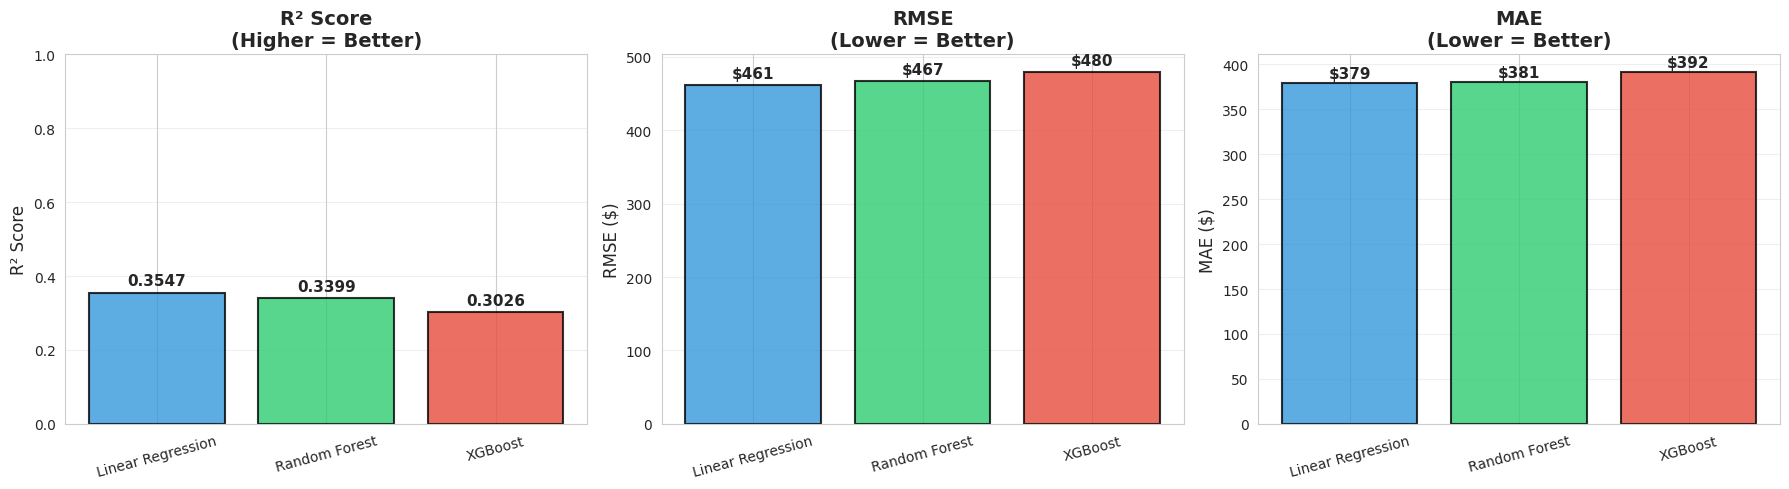


🏆 BEST MODEL: Linear Regression
   R² Score: 0.3547 (35.47% variance explained)


In [55]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R² Score': [lr_r2, rf_r2, xgb_r2],
    'RMSE ($)': [lr_rmse, rf_rmse, xgb_rmse],
    'MAE ($)': [lr_mae, rf_mae, xgb_mae]
})

print("\n📊 Performance Summary:")
display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors_compare = ['#3498db', '#2ecc71', '#e74c3c']

# R² Score
bars1 = axes[0].bar(comparison_df['Model'], comparison_df['R² Score'],
                    color=colors_compare, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('R² Score\n(Higher = Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars1, comparison_df['R² Score'])):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 0.02,
                f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)
axes[0].tick_params(axis='x', rotation=15)

# RMSE
bars2 = axes[1].bar(comparison_df['Model'], comparison_df['RMSE ($)'],
                    color=colors_compare, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title('RMSE\n(Lower = Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE ($)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars2, comparison_df['RMSE ($)'])):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 10,
                f'${v:,.0f}', ha='center', fontweight='bold', fontsize=11)
axes[1].tick_params(axis='x', rotation=15)

# MAE
bars3 = axes[2].bar(comparison_df['Model'], comparison_df['MAE ($)'],
                    color=colors_compare, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_title('MAE\n(Lower = Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAE ($)', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars3, comparison_df['MAE ($)'])):
    axes[2].text(bar.get_x() + bar.get_width()/2, v + 5,
                f'${v:,.0f}', ha='center', fontweight='bold', fontsize=11)
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Find best model
best_idx = comparison_df['R² Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_r2 = comparison_df.loc[best_idx, 'R² Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f} ({best_r2*100:.2f}% variance explained)")

# SECTION 11: SAVE MODELS

In [56]:
print("\n" + "="*80)
print("SAVING MODELS")
print("="*80)

joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

with open('feature_names.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)

print("✅ All models saved successfully!")

# Download models
print("\n📥 Downloading model files...")
files.download('linear_regression_model.pkl')
files.download('random_forest_model.pkl')
files.download('xgboost_model.pkl')
files.download('scaler.pkl')
files.download('label_encoders.pkl')
files.download('feature_names.pkl')


SAVING MODELS
✅ All models saved successfully!

📥 Downloading model files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SECTION 12: BUSINESS INSIGHTS & ANALYTICS

In [58]:
print("\n" + "="*80)
print("📊 BUSINESS INSIGHTS & ANALYTICS")
print("="*80)

# Calculate key metrics
print("\n💡 KEY INSIGHTS:\n")

# 1. Average prediction accuracy
accuracy_percentage = best_r2 * 100
print(f"1. Model Accuracy: {accuracy_percentage:.2f}%")
print(f"   The {best_model_name} model explains {accuracy_percentage:.2f}% of sales variance")

# 2. Average error
print(f"\n2. Average Prediction Error: ${best_mae:,.2f}")
print(f"   On average, predictions are off by ${best_mae:,.2f}")

# 3. Top features
print(f"\n3. Top 3 Most Important Features:")
if best_model_name == 'Random Forest':
    top_3 = feature_importance.head(3)
else:
    top_3 = feature_importance_xgb.head(3)

for idx, row in top_3.iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.4f}")

# 4. Prediction distribution
good_predictions = sum(1 for c in (colors_rf if best_model_name == 'Random Forest' else colors_xgb) if c == 'green')
total_predictions = len(colors_rf if best_model_name == 'Random Forest' else colors_xgb)
good_percentage = (good_predictions / total_predictions) * 100

print(f"\n4. Prediction Quality:")
print(f"   • Good Predictions (Green): {good_predictions:,} ({good_percentage:.1f}%)")
print(f"   • Poor Predictions (Red): {total_predictions - good_predictions:,} ({100-good_percentage:.1f}%)")

# 5. Sales statistics
print(f"\n5. Sales Statistics:")
print(f"   • Average Actual Sales: ${y_test.mean():,.2f}")
print(f"   • Min Sales: ${y_test.min():,.2f}")
print(f"   • Max Sales: ${y_test.max():,.2f}")

# Create interactive Plotly visualization
print("\n📈 Creating interactive visualizations...")

# Interactive scatter plot
fig = go.Figure()

if best_model_name == 'Linear Regression':
    y_pred_best = y_pred_lr_test
    colors_best = colors
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf_test
    colors_best = colors_rf
else:
    y_pred_best = y_pred_xgb_test
    colors_best = colors_xgb

# Separate good and poor predictions
good_mask = [c == 'green' for c in colors_best]
poor_mask = [c == 'red' for c in colors_best]

# Good predictions
fig.add_trace(go.Scatter(
    x=y_test[good_mask],
    y=y_pred_best[good_mask],
    mode='markers',
    name='Good Predictions',
    marker=dict(color='green', size=8, opacity=0.6),
    hovertemplate='<b>Actual:</b> $%{x:,.2f}<br><b>Predicted:</b> $%{y:,.2f}<extra></extra>'
))

# Poor predictions
fig.add_trace(go.Scatter(
    x=y_test[poor_mask],
    y=y_pred_best[poor_mask],
    mode='markers',
    name='Poor Predictions',
    marker=dict(color='red', size=8, opacity=0.6),
    hovertemplate='<b>Actual:</b> $%{x:,.2f}<br><b>Predicted:</b> $%{y:,.2f}<extra></extra>'
))

# Perfect prediction line
fig.add_trace(go.Scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(color='black', width=2, dash='dash')
))

fig.update_layout(
    title=f'{best_model_name}: Interactive Prediction Analysis<br><sub>🟢 Good Predictions | 🔴 Poor Predictions</sub>',
    xaxis_title='Actual Sales ($)',
    yaxis_title='Predicted Sales ($)',
    hovermode='closest',
    height=600,
    template='plotly_white',
    font=dict(size=12)
)

fig.show()

# Feature importance interactive chart
if best_model_name in ['Random Forest', 'XGBoost']:
    importance_data = feature_importance if best_model_name == 'Random Forest' else feature_importance_xgb
    top_10_features = importance_data.head(10)

    fig2 = go.Figure(go.Bar(
        x=top_10_features['Importance'],
        y=top_10_features['Feature'],
        orientation='h',
        marker=dict(
            color=top_10_features['Importance'],
            colorscale='Viridis',
            showscale=True
        ),
        hovertemplate='<b>%{y}</b><br>Importance: %{x:.4f}<extra></extra>'
    ))

    fig2.update_layout(
        title=f'{best_model_name}: Feature Importance Analysis',
        xaxis_title='Importance Score',
        yaxis_title='Feature',
        height=500,
        template='plotly_white',
        yaxis=dict(autorange='reversed'),
        font=dict(size=12)
    )

    fig2.show()

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print(f"\n🎉 Your {best_model_name} model is ready for deployment!")
print(f"📊 Model Performance: R² = {best_r2:.4f}, MAE = ${best_mae:,.2f}")
print(f"💾 All models have been saved and downloaded")
print(f"🎨 Interactive dashboard is active above")
print("\n" + "="*80)


📊 BUSINESS INSIGHTS & ANALYTICS

💡 KEY INSIGHTS:

1. Model Accuracy: 35.47%
   The Linear Regression model explains 35.47% of sales variance

2. Average Prediction Error: $379.31
   On average, predictions are off by $379.31

3. Top 3 Most Important Features:
   • Profit: 0.3790
   • Discount: 0.0767
   • Quarter: 0.0741

4. Prediction Quality:
   • Good Predictions (Green): 1,499 (75.0%)
   • Poor Predictions (Red): 500 (25.0%)

5. Sales Statistics:
   • Average Actual Sales: $1,497.85
   • Min Sales: $500.00
   • Max Sales: $2,500.00

📈 Creating interactive visualizations...



✅ ANALYSIS COMPLETE!

🎉 Your Linear Regression model is ready for deployment!
📊 Model Performance: R² = 0.3547, MAE = $379.31
💾 All models have been saved and downloaded
🎨 Interactive dashboard is active above

